# Generating Title from the body of text

### Importing Dependencies

In [69]:
import pandas as pd
import numpy as np
from bs4 import BeautifulSoup as bs
import os
import requests
import json
import transformers
from transformers import AutoTokenizer, AutoModel, AdamW, get_linear_schedule_with_warmup
from transformers import T5Tokenizer, T5ForConditionalGeneration
from transformers.optimization import  Adafactor
import torch
import torch.nn.functional as F
from torch.utils.data import Dataset, DataLoader
from tqdm import tqdm, trange
from transformers.trainer_utils import set_seed
import time
import torch.nn.functional as F
from torch.utils.data import DataLoader
from transformers import AutoTokenizer, AutoModelForSeq2SeqLM, DataCollatorForSeq2Seq, Seq2SeqTrainingArguments, Seq2SeqTrainer
from datasets import load_from_disk
import nltk
from nltk.tokenize import sent_tokenize
import pytorch_lightning as pl
from pytorch_lightning.callbacks import ModelCheckpoint
from pytorch_lightning.loggers import TensorBoardLogger
import matplotlib.pyplot as plt
import seaborn as sns

import warnings
warnings.filterwarnings("ignore")

In [70]:
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print(device)

cuda:0


In [71]:
#Checking for the GPU availability

if torch.cuda.is_available():
    dev = torch.device("cuda:0")
    print("Running on the GPU")
else:
    dev = torch.device("cpu")
    print("Running on the CPU")

Running on the GPU


## Preparing the data

### 1. Legal Data

In [72]:
# iterate over files in that directory
def get_docs(directory):
  docs = []
  for filename in os.listdir(directory):
      f = os.path.join(directory, filename)
      # checking if it is a file
      if os.path.isfile(f):
        docs.append(f)
  return docs

def read_file(file):
  content = []

  # Read the XML file
  with open(file, "r", encoding = 'utf-8', errors='ignore') as file:
      # Read each line in the file, readlines() returns a list of lines
      content = file.readlines()

  # Combine the lines in the list into a string
  content = "".join(content)
  bs_content = bs(content, "lxml")
  return bs_content

# Function for parsing the data based on tags
def get_data(doc,tag):
  tag_data = doc.find_all(tag)
  xlist = []
  for text in tag_data:
    xlist.append(text.get_text())

  return xlist

In [73]:
docs = get_docs(r'C:\aryan\text_gen_bert\data\fulltext')

In [74]:
df = pd.DataFrame(docs, columns=['docs'])
df['raw_data'] = df['docs'].apply(read_file)
df['name'] = df['raw_data'].apply(get_data, tag = "name").apply(lambda row: ' '.join(row))
df['subject'] = df['raw_data'].apply(get_data, tag = "catchphrases").apply(lambda row: ' '.join(row))
df['body'] = df['raw_data'].apply(get_data, tag = "sentences").apply(lambda row: ' '.join(row))
df['filename'] = df['docs'].str.rsplit("\\", n=1, expand=True)[1].to_list()
# df.set_index('filename',inplace=True)
# df.index.name = None
df.drop(columns=['docs','raw_data'], inplace=True)

In [187]:
df.tail(10)

,name,subject,body,filename
3907,Combined Gunggandji People v State of Queensla...,\ndeed of grant of land in trust\nwhether leas...,"\n\n GENERAL \n In these proceedings, Mr Les M...",09_979.xml
3908,Allphones Retail Pty Limited v Australian Comp...,\npreliminary discovery\nidentity discovery\na...,\n\n INTRODUCTION \n In these proceedings the ...,09_980.xml
3909,Purcell v APS Chemicals Superannuation Pty Ltd...,\nappeal from superannuation complaints tribun...,\n\n Ms Susan Purcell claims an entitlement to...,09_981.xml
3910,Hneidi v Minister for Immigration & Citizenshi...,\nappeal from decision of administrative appea...,\n\n \n 1 This is an appeal from a decision of...,09_983.xml
3911,Minister for Immigration and Citizenship v SZK...,\ns 424 of migration act 1958 (cth)\nhigh cour...,\n\n INTRODUCTION \n The appellant (Minister) ...,09_984.xml
3912,Makucha v Fairbrook PMA Pty Ltd [2009] FCA 985...,\napplication for extension of time to appeal ...,\n\n This is an application for an extension o...,09_985.xml
3913,SZMPT v Minister for Immigration and Citizensh...,\ncourt may have regard to reasons of tribunal...,\n\n INTRODUCTION \n This is an appeal from or...,09_99.xml
3914,Kowalski v Mitsubishi Motors Australia Ltd [20...,"\napplication for judgment, for dismissal of p...",\n\n Mr Kazimir Kowalski has brought a proceed...,09_991.xml
3915,Shu Uan Eao v Commissioner of Taxation of the ...,\nprocedural fairness\nwhether inadequate inte...,\n\n One of the principal determinative issues...,09_992.xml
3916,"Mcjannett, in the matter of an application for...",\napplication for leave to issue a subpoena to...,"\n\n ISSUE \n The issue for determination, the...",09_996.xml


In [75]:
df.head()

,name,subject,body,filename
0,Sharman Networks Ltd v Universal Music Austral...,\napplication for leave to appeal\nauthorisati...,\n\n Background to the current application \n ...,06_1.xml
1,Lawrance v Human Rights and Equal Opportunity ...,\nno point of principle\nadministrative law an...,\n\n \n 1 These are two applications for order...,06_100.xml
2,Citrus Queensland Pty Ltd v Sunstate Orchards ...,\ndiscovery\nwhether inclusion of a document a...,\n\n \n 1 I have before me two notices of moti...,06_1001.xml
3,Martech International Pty Ltd v Energy World C...,\nvariation\ntermination\ninterpretation\nmana...,\n\n \n Introduction \n \n1 In 1985 Mr Fletche...,06_1004.xml
4,Commissioner of Taxation v Milne (with Corrige...,\ncontext of liability to income tax\nreview o...,\n\n Context to the present application by way...,06_1005.xml


In [76]:
legal_docs = df.copy()[['name','body']]
legal_docs.columns = ['title', 'body']
legal_docs.head()

,title,body
0,Sharman Networks Ltd v Universal Music Austral...,\n\n Background to the current application \n ...
1,Lawrance v Human Rights and Equal Opportunity ...,\n\n \n 1 These are two applications for order...
2,Citrus Queensland Pty Ltd v Sunstate Orchards ...,\n\n \n 1 I have before me two notices of moti...
3,Martech International Pty Ltd v Energy World C...,\n\n \n Introduction \n \n1 In 1985 Mr Fletche...
4,Commissioner of Taxation v Milne (with Corrige...,\n\n Context to the present application by way...


### 2. Research Papers Data

In [77]:
data_file = 'C:/aryan/text_to_title_gen/data/arxiv-metadata-oai-snapshot.json'

def get_metadata():
    with open(data_file, 'r') as f:
        for line in f:
            yield line

In [78]:
metadata = get_metadata()
for paper in metadata:
    paper_dict = json.loads(paper)
    print('Title: {}\n\nAbstract: {}\nRef: {}'.format(paper_dict.get('title'), paper_dict.get('abstract'), paper_dict.get('journal-ref')))
#     print(paper)
    break

Title: Calculation of prompt diphoton production cross sections at Tevatron and
  LHC energies

Abstract:   A fully differential calculation in perturbative quantum chromodynamics is
presented for the production of massive photon pairs at hadron colliders. All
next-to-leading order perturbative contributions from quark-antiquark,
gluon-(anti)quark, and gluon-gluon subprocesses are included, as well as
all-orders resummation of initial-state gluon radiation valid at
next-to-next-to-leading logarithmic accuracy. The region of phase space is
specified in which the calculation is most reliable. Good agreement is
demonstrated with data from the Fermilab Tevatron, and predictions are made for
more detailed tests with CDF and DO data. Predictions are shown for
distributions of diphoton pairs produced at the energy of the Large Hadron
Collider (LHC). Distributions of the diphoton pairs from the decay of a Higgs
boson are contrasted with those produced from QCD processes at the LHC, showing
tha

In [79]:
titles = []
abstracts = []
years = []
metadata = get_metadata()
for paper in metadata:
    paper_dict = json.loads(paper)
    ref = paper_dict.get('journal-ref')
    try:
        year = int(ref[-4:])
        if 2000 < year < 2023:
            years.append(year)
            titles.append(paper_dict.get('title'))
            abstracts.append(paper_dict.get('abstract'))
    except:
        pass

len(titles), len(abstracts), len(years)

(155668, 155668, 155668)

In [80]:
papers = pd.DataFrame({'title': titles,'abstract': abstracts,'year': years})
papers.head()

,title,abstract,year
0,Calculation of prompt diphoton production cros...,A fully differential calculation in perturba...,2007
1,Polymer Quantum Mechanics and its Continuum Limit,A rather non-standard quantum representation...,2007
2,"The Spitzer c2d Survey of Large, Nearby, Inste...",We discuss the results from the combined IRA...,2007
3,Fermionic superstring loop amplitudes in the p...,The pure spinor formulation of the ten-dimen...,2007
4,Lifetime of doubly charmed baryons,"In this work, we evaluate the lifetimes of t...",2008


In [81]:
# Adding <input_text> and <target_text> columns
papers = papers[['title','abstract']]
papers.columns = ['title', 'body']
papers.head()


,title,body
0,Calculation of prompt diphoton production cros...,A fully differential calculation in perturba...
1,Polymer Quantum Mechanics and its Continuum Limit,A rather non-standard quantum representation...
2,"The Spitzer c2d Survey of Large, Nearby, Inste...",We discuss the results from the combined IRA...
3,Fermionic superstring loop amplitudes in the p...,The pure spinor formulation of the ten-dimen...
4,Lifetime of doubly charmed baryons,"In this work, we evaluate the lifetimes of t..."


In [82]:
# Setting aside 500 research papers for testing and model evaluation
papers_train = papers[:-500]
papers_test = papers[-500:]

In [83]:
# Setting aside 500 legal docs for testing and model evaluation
legal_docs_train = legal_docs[:-500]
legal_docs_test = legal_docs[-500:]

In [84]:
print('Legal Docs - train Shape: {}, \nResearch Papers - train Shape: {}'.format(legal_docs_train.shape, papers_train.shape))
print(' ')
print('Legal Docs - test Shape: {}, \nResearch Papers - test Shape: {}'.format(legal_docs_test.shape, papers_test.shape))

Legal Docs - train Shape: (3417, 2), 
Research Papers - train Shape: (155168, 2)
 
Legal Docs - test Shape: (500, 2), 
Research Papers - test Shape: (500, 2)


In [85]:
legal_docs_train = legal_docs_train.head(2000)
papers_train = papers_train.head(10000)

### 3. Merging the datasets

In [150]:
final_df = pd.concat([legal_docs_train, papers_train], axis=0, ignore_index=True)
final_df.shape

(12000, 2)

In [151]:
final_test_df = pd.concat([legal_docs_test, papers_test], axis=0, ignore_index=True)
final_test_df.columns = ['headline', 'article']
final_test_df.shape

(1000, 2)

In [152]:
final_df['title'] = final_df['title'].astype(str)
final_df['body'] = final_df['body'].astype(str)
final_df.columns = ['headline', 'article']

final_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 12000 entries, 0 to 11999
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   headline  12000 non-null  object
 1   article   12000 non-null  object
dtypes: object(2)
memory usage: 187.6+ KB


### 4. Train-Test Split

In [153]:
from sklearn.model_selection import train_test_split
train_df, rest_df = train_test_split(final_df, test_size=0.2)
test_df, val_df = train_test_split(rest_df, test_size=0.5)

# train_df = train_df.head()
# test_df = test_df.head()
# val_df = val_df.head()
train_df.shape, test_df.shape, val_df.shape

((9600, 2), (1200, 2), (1200, 2))

## Training the T5 LLM to generate the headline

In [154]:
MODEL_NAME = "t5-base" #smallest t5 model

tokenizer = T5Tokenizer.from_pretrained(MODEL_NAME, model_max_length = 1024) # , model_max_length=10000

In [155]:
article_token_counts, headline_token_counts = [], []

for _, row in train_df.iterrows():
    article_token_count = len(tokenizer.encode(row["article"]))
    article_token_counts.append(article_token_count)

    headline_token_count = len(tokenizer.encode(row["headline"]))
    headline_token_counts.append(headline_token_count)

Token indices sequence length is longer than the specified maximum sequence length for this model (10397 > 1024). Running this sequence through the model will result in indexing errors


In [156]:
final_df["article"].str.len().max(), final_df["headline"].str.len().max()

(2551596, 398)

In [93]:
class NewsHeadlineDataset(Dataset):

    def __init__(
        self,
        data: pd.DataFrame,
        tokenizer: T5Tokenizer,
        article_max_token_len: int = 512,
        headline_max_token_len: int = 128
    ):

        self.tokenizer = tokenizer
        self.data = data
        self.article_max_token_len = article_max_token_len
        self.headline_max_token_len = headline_max_token_len

    def __len__(self):
        return len(self.data)

    def __getitem__(self, index: int):
        data_row = self.data.iloc[index]

        article = data_row["article"]

        article_encoding = tokenizer(
            article,
            max_length=self.article_max_token_len,
            padding="max_length",
            truncation=True,
            return_attention_mask=True,
            add_special_tokens=True,
            return_tensors="pt"
        )

        headline_encoding = tokenizer(
            data_row["headline"],
            max_length=self.headline_max_token_len,
            padding="max_length",
            truncation=True,
            return_attention_mask=True,
            add_special_tokens=True,
            return_tensors="pt"
        )

        labels = headline_encoding["input_ids"]
        # giving padding (encoded with 0s) value of -100 so that it doesn't get counted in loss func, from docs
        labels[labels == 0] = -100

        return dict(
            article=article,
            headline=data_row["headline"],
            article_input_ids=article_encoding["input_ids"].flatten(),
            article_attention_mask=article_encoding["attention_mask"].flatten(),
            labels=labels.flatten(),
            labels_attention_mask=headline_encoding["attention_mask"].flatten()
        )

In [94]:
class NewsHeadlineDataModule(pl.LightningDataModule):

    def __init__(
        self,
        train_df: pd.DataFrame,
        test_df: pd.DataFrame,
        val_df: pd.DataFrame,
        tokenizer: T5Tokenizer,
        batch_size: int = 4,
        article_max_token_len: int = 512,
        headline_max_token_len: int = 128
    ):

        super().__init__()

        self.train_df = train_df
        self.test_df = test_df
        self.val_df = val_df

        self.batch_size = batch_size
        self.tokenizer = tokenizer
        self.article_max_token_len = article_max_token_len
        self.headline_max_token_len = headline_max_token_len

    def setup(self, stage=None):
        self.train_dataset = NewsHeadlineDataset(
            self.train_df,
            self.tokenizer,
            self.article_max_token_len,
            self.headline_max_token_len
        )

        self.test_dataset = NewsHeadlineDataset(
            self.test_df,
            self.tokenizer,
            self.article_max_token_len,
            self.headline_max_token_len
        )

        self.val_dataset = NewsHeadlineDataset(
            self.val_df,
            self.tokenizer,
            self.article_max_token_len,
            self.headline_max_token_len
        )

    def train_dataloader(self):
        return DataLoader(
            self.train_dataset,
            batch_size=self.batch_size,
            shuffle=True, # used for training
            num_workers=0
        )

    def val_dataloader(self):
        return DataLoader(
            self.test_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=0
        )

    def test_dataloader(self):
        return DataLoader(
            self.val_dataset,
            batch_size=self.batch_size,
            shuffle=False,
            num_workers=0
        )

### Model Building

In [29]:
N_EPOCHS = 10
BATCH_SIZE = 1

data_module = NewsHeadlineDataModule(train_df, test_df, val_df, tokenizer, batch_size=BATCH_SIZE)

In [30]:
class NewsHeadlineModel(pl.LightningModule):

    def __init__(self):
        super().__init__()
        self.model = T5ForConditionalGeneration.from_pretrained(MODEL_NAME, return_dict=True)
        self.val_loss = []
        self.val_loss_epoch = []

    def forward(self, input_ids, attention_mask, decoder_attention_mask, labels=None):
        # if we have labels we are going to have decoder_attenttion_mask which is calculated from the summary encoding and the labels

        output = self.model(
            input_ids,
            attention_mask=attention_mask,
            labels=labels,
            decoder_attention_mask=decoder_attention_mask
        )

        return output.loss, output.logits

    def training_step(self, batch, batch_idx):
        input_ids = batch["article_input_ids"]
        attention_mask = batch["article_attention_mask"]
        labels = batch["labels"]
        labels_attention_mask = batch["labels_attention_mask"]

        loss, outputs = self(
            input_ids=input_ids,
            attention_mask=attention_mask,
            decoder_attention_mask=labels_attention_mask,
            labels=labels
        )

        self.log("train_loss", loss, prog_bar=True, logger=True)
        return loss

    def validation_step(self, batch, batch_idx):
        input_ids = batch["article_input_ids"]
        attention_mask = batch["article_attention_mask"]
        labels = batch["labels"]
        labels_attention_mask = batch["labels_attention_mask"]

        loss, outputs = self(
            input_ids=input_ids,
            attention_mask=attention_mask,
            decoder_attention_mask=labels_attention_mask,
            labels=labels
        )

        self.log("val_loss", loss, prog_bar=True, logger=True)
        self.val_loss.append(loss)
        return loss

    def on_validation_epoch_end(self):
      avg = sum(self.val_loss)/len(self.val_loss)
      self.val_loss_epoch.append(avg)
      self.val_loss = []
    #   avg_loss = torch.stack([x["val_loss"] for x in outputs]).mean()
    #   self.logger.experiment.add_scalar('loss',avg_loss, self.current_epoch)

    def test_step(self, batch, batch_idx):
        input_ids = batch["article_input_ids"]
        attention_mask = batch["article_attention_mask"]
        labels = batch["labels"]
        labels_attention_mask = batch["labels_attention_mask"]

        loss, outputs = self(
            input_ids=input_ids,
            attention_mask=attention_mask,
            decoder_attention_mask=labels_attention_mask,
            labels=labels
        )

        self.log("test_loss", loss, prog_bar=True, logger=True)
        return loss

    def configure_optimizers(self):
        return torch.optim.AdamW(self.parameters(), lr=0.0001)

In [31]:
%%time
model = NewsHeadlineModel()

CPU times: total: 406 ms
Wall time: 1.07 s


In [32]:
checkpoint_callback = ModelCheckpoint(
    dirpath="checkpoints",
    filename="best-checkpoint",
    save_top_k=1,
    verbose=True,
    monitor="val_loss",
    mode="min"
)

logger = TensorBoardLogger("lightning_logs", name="news-headline")

trainer = pl.Trainer(
    logger=logger,
    callbacks=checkpoint_callback,
    max_epochs=N_EPOCHS,
    # gpus=1
    accelerator='gpu'  # Use 'ddp' for single GPU
)

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs


In [33]:
torch.set_float32_matmul_precision('high')

def new_func():
    trainer.fit(model, data_module)

new_func()

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name  | Type                       | Params
-----------------------------------------------------
0 | model | T5ForConditionalGeneration | 222 M 
-----------------------------------------------------
222 M     Trainable params
0         Non-trainable params
222 M     Total params
891.614   Total estimated model params size (MB)


Epoch 0: 100%|██████████| 9600/9600 [20:01<00:00,  7.99it/s, v_num=6, train_loss=2.990, val_loss=1.750]

Epoch 0, global step 9600: 'val_loss' reached 1.75337 (best 1.75337), saving model to 'C:\\aryan\\text_to_title_gen\\checkpoints\\best-checkpoint.ckpt' as top 1


Epoch 1: 100%|██████████| 9600/9600 [21:23<00:00,  7.48it/s, v_num=6, train_loss=1.430, val_loss=1.730]  

Epoch 1, global step 19200: 'val_loss' reached 1.72529 (best 1.72529), saving model to 'C:\\aryan\\text_to_title_gen\\checkpoints\\best-checkpoint.ckpt' as top 1


Epoch 2: 100%|██████████| 9600/9600 [26:16<00:00,  6.09it/s, v_num=6, train_loss=0.659, val_loss=1.760]  

Epoch 2, global step 28800: 'val_loss' was not in top 1


Epoch 3: 100%|██████████| 9600/9600 [26:11<00:00,  6.11it/s, v_num=6, train_loss=0.670, val_loss=1.820]  

Epoch 3, global step 38400: 'val_loss' was not in top 1


Epoch 4: 100%|██████████| 9600/9600 [25:30<00:00,  6.27it/s, v_num=6, train_loss=0.0617, val_loss=1.930] 

Epoch 4, global step 48000: 'val_loss' was not in top 1


Epoch 5: 100%|██████████| 9600/9600 [19:54<00:00,  8.04it/s, v_num=6, train_loss=0.733, val_loss=2.010]  

Epoch 5, global step 57600: 'val_loss' was not in top 1


Epoch 6: 100%|██████████| 9600/9600 [19:48<00:00,  8.08it/s, v_num=6, train_loss=1.080, val_loss=2.120]   

Epoch 6, global step 67200: 'val_loss' was not in top 1


Epoch 7: 100%|██████████| 9600/9600 [21:04<00:00,  7.59it/s, v_num=6, train_loss=0.718, val_loss=2.220]   

Epoch 7, global step 76800: 'val_loss' was not in top 1


Epoch 8: 100%|██████████| 9600/9600 [25:51<00:00,  6.19it/s, v_num=6, train_loss=0.640, val_loss=2.320]   

Epoch 8, global step 86400: 'val_loss' was not in top 1


Epoch 9: 100%|██████████| 9600/9600 [20:28<00:00,  7.81it/s, v_num=6, train_loss=0.341, val_loss=2.420]   

Epoch 9, global step 96000: 'val_loss' was not in top 1
`Trainer.fit` stopped: `max_epochs=10` reached.


Epoch 9: 100%|██████████| 9600/9600 [20:28<00:00,  7.81it/s, v_num=6, train_loss=0.341, val_loss=2.420]


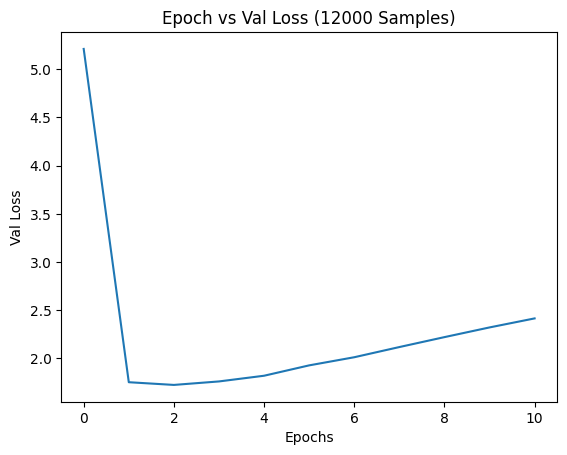

In [34]:
a = model.val_loss_epoch
a = torch.Tensor(a).cpu()
plt.plot([0,1,2,3,4,5,6,7,8,9,10], a)
plt.xlabel("Epochs")
plt.ylabel("Val Loss")
plt.title("Epoch vs Val Loss (12000 Samples)")
plt.savefig('Epoch vs Val Loss (12000 Samples).png')
plt.show()

In [138]:
# Saving checkpoint
custom_path = "C:/aryan/text_to_title_gen/checkpoints/best-checkpoint_12000samples.ckpt"

trained_model = NewsHeadlineModel.load_from_checkpoint(custom_path)

trained_model.freeze()

In [139]:
# To generate the headline

def generate_headline(text):
  text_encoding = tokenizer(
      text,
      max_length=512,
      padding="max_length",
      truncation=True,
      return_attention_mask=True,
      add_special_tokens=True,
      return_tensors="pt"
  )

  generated_ids = trained_model.model.generate(
      input_ids=text_encoding["input_ids"].to(device),
      attention_mask=text_encoding["attention_mask"].to(device),
      max_length=150,
      num_beams=2, # beam search
      repetition_penalty=2.5,
      length_penalty=1.0,
      early_stopping=True # To speed up the process
  )

  preds = [
      tokenizer.decode(gen_id, skip_special_tokens=True, clean_up_tokenization_spaces=True)
      for gen_id in generated_ids
  ]

  return "".join(preds)

## Generating Headlines

In [157]:
def gen_test(text, row):
    sample_row = text.iloc[row]
    text = sample_row["article"]
    print("Lenth of the body:", len(text.split()))
    print("\n")
    print("Text body:", text)
    print("\n")
    print("Actual Headline:", sample_row["headline"])
    print("\n")
    print("Generated Headline:", generate_headline(text))


In [158]:
gen_test(final_test_df, 10)

Lenth of the body: 6806


Text body: 

 THE PRESENT APPLICATION 
 On 4 November 2008, Cowdroy J delivered judgment in Rahman v Secretary, Department of Education, Employment and Workplace Relations [2008] FCA 1634.
On that day, his Honour dismissed Mr Rahman's application with costs.
On the same day, his Honour delivered his reasons for making those orders.
The proceedings before his Honour concerned an application for Austudy payments made by the applicant which was rejected by a delegate of the respondent on the ground that the value of the applicant's net assets exceeded the upper limit for the value of assets allowable under the relevant legislation.
The time within which the applicant might have appealed from his Honour's decision expired on 25 November 2008.
The applicant did not file any Notice of Appeal by 25 November 2008.
On 16 February 2009, the applicant filed an Application for Extension of Time to File and Serve a Notice of Appeal in order to enable him to appeal from the

In [159]:
gen_test(final_test_df, 20)

Lenth of the body: 9480


Text body: 

 On 10 February 2009 the Australian Securities and Investments Commission ("the Commission") filed an application seeking urgent interlocutory relief against two individuals and eight companies, the defendants in this proceeding.
The relief sought was the preservation of the assets of all the defendants and a restraint on the disposition of any of those assets.
The Commission further sought orders against the first and second defendants restraining them from applying for passports or leaving Australia.
On 11 and 12 February 2009 I made orders operative for a very short time restraining the defendants from disposing of their assets and restraining the first and second defendants from leaving Australia.
On 13 February 2009 I made further orders restraining the defendants from disposing of their assets and restraining the first and second defendants from leaving Australia pending further order.
That order contained provisos allowing for the defendant

In [160]:
gen_test(final_test_df, 250)

Lenth of the body: 5100


Text body: 

 INTRODUCTION 
 This matter relates to a challenge by the applicant of an assessment by the respondent under Part IVA of the Income Tax Assessment Act 1936 (Cth) (the ITAA 1936) that the applicant obtained a tax benefit of $82,950,090 in connection with a scheme to reduce income tax liability.
The matter is listed for hearing, commencing on 13 July 2009.
The applicant by notice of motion of 5 May 2009 now seeks further and better particulars of: 
 1.1 the events and transactions which the Respondent alleges would have occurred had the 'scheme' pleaded in paragraph 46 of the Respondent's Response to the Applicant's Statement of Grounds not been entered into; and 

 
 1.2 the essential terms on which it is alleged that those events and transactions would have been implemented, 

 
 or such other particulars as the Court considers appropriate in the circumstances.


 BACKGROUND 
 The history of this matter, and another related matter, are described i

In [161]:
gen_test(final_test_df, 510)

Lenth of the body: 81


Text body:   We demonstrate complete characterization of a two-qubit entangling process -
a linear optics controlled-NOT gate operating with coincident detection - by
quantum process tomography. We use maximum-likelihood estimation to convert the
experimental data into a physical process matrix. The process matrix allows
accurate prediction of the operation of the gate for arbitrary input states,
and calculation of gate performance measures such as the average gate fidelity,
average purity and entangling capability of our gate, which are 0.90, 0.83 and
0.73, respectively.



Actual Headline: Quantum process tomography of a controlled-NOT gate


Generated Headline: Quantum process tomography of a two-qubit entangling gate


In [162]:
gen_test(final_test_df, 650)

Lenth of the body: 75


Text body:   We examine the execution of general U(1) transformations on programmable
quantum processors. We show that, with only the minimal assumption of
availability of copies of the one-qubit program state, that the apparent
advantage of existing schemes proposed by G.Vidal it et al. [Phys. Rev. Lett.
88, 047905 (2002)] and M.Hillery et al. [Phys. Rev. A. 65, 022301 (2003)] to
execute a general U(1) transformation with greater probability using complex
program states appears not to hold.



Actual Headline: Probabilistic programmable quantum processors with multiple copies of
  program state


Generated Headline: General U(1) Transformations on Programmable Quantum Processors


In [163]:
gen_test(final_test_df, 779)

Lenth of the body: 132


Text body:   On the basis of the non-commutative q-calculus, we investigate a
q-deformation of the classical Poisson bracket in order to formulate a
generalized q-deformed dynamics in the classical regime. The obtained
q-deformed Poisson bracket appears invariant under the action of the
q-symplectic group of transformations. In this framework we introduce the
q-deformed Hamilton's equations and we derive the evolution equation for some
simple q-deformed mechanical systems governed by a scalar potential dependent
only on the coordinate variable. It appears that the q-deformed Hamiltonian,
which is the generator of the equation of motion, is generally not conserved in
time but, in correspondence, a new constant of motion is generated. Finally, by
following the standard canonical quantization rule, we compare the well known
q-deformed Heisenberg algebra with the algebra generated by the q-deformed
Poisson bracket.



Actual Headline: Classical and quantum q-deform

In [164]:
gen_test(final_test_df, 888)

Lenth of the body: 181


Text body:   We have analyzed available optical data for Au in the mid-infrared range
which is important for a precise prediction of the Casimir force. Significant
variation of the data demonstrates genuine sample dependence of the dielectric
function. We demonstrate that the Casimir force is largely determined by the
material properties in the low frequency domain and argue that therefore the
precise values of the Drude parameters are crucial for an accurate evaluation
of the force. These parameters can be estimated by two different methods,
either by fitting real and imaginary parts of the dielectric function at low
frequencies, or via a Kramers-Kronig analysis based on the imaginary part of
the dielectric function in the extended frequency range. Both methods lead to
very similar results. We show that the variation of the Casimir force
calculated with the use of different optical data can be as large as 5% and at
any rate cannot be ignored. To have a reliabl

In [165]:
final_test_df.head()

,headline,article
0,"Williams v Construction, Forestry, Mining and ...",\n\n INTRODUCTION \n This is an application by...
1,Alfred v Wakelin (No 3) [2009] FCA 224 (13 Mar...,\n\n By notice of motion filed on 18 February ...
2,Commonwealth Bank of Australia v Deputy Commis...,\n\n In this proceeding the Commonwealth Bank ...
3,Mortimer v Opes Prime Stockbroking Limited (AC...,\n\n INTRODUCTION \n There are two application...
4,Habib v Commonwealth of Australia (No 2) [2009...,"\n\n Introduction\n Save where indicated, the ..."


In [170]:
final_test_df['generated_headline'] = final_test_df['article'].apply(lambda row: generate_headline(row))

## Evaluation

### BLEU Score

In [174]:
from nltk.translate.bleu_score import SmoothingFunction, corpus_bleu, sentence_bleu 


def bleu(ref, gen):
    cc = SmoothingFunction()
    score_bleu = sentence_bleu(ref.split(), gen.split(), weights=(1,0,0,0), smoothing_function=cc.method4) 
    return score_bleu

In [175]:
dataset_references = list(final_test_df['headline']) # List of reference sentences for the dataset
dataset_generated = list(final_test_df['generated_headline'])  # List of generated sentences for the dataset

total_score = 0.0
total_pairs = len(dataset_references)
print("Total Pairs: ",total_pairs)

for ref, gen in zip(dataset_references, dataset_generated):
    # print(ref.lower().split())
    # print(gen.lower().split())
    score = bleu(ref.lower(), gen.lower())
    # print(score)
    total_score += score
    # print(total_score)

average_bleu = total_score / total_pairs

print("Average BLEU score for the dataset:", average_bleu)

Total Pairs:  1000
Average BLEU score for the dataset: 0.05074094370970452


### ROUGE Score

In [116]:
# !pip install rouge


In [117]:
from rouge import Rouge
ROUGE = Rouge()

In [118]:
sample_row = final_test_df.iloc[1]
text = sample_row["article"]
reference = sample_row["headline"]
candidate = generate_headline(text)

In [119]:
x = ROUGE.get_scores(candidate, reference)
x[0]

{'rouge-1': {'r': 0.36363636363636365, 'p': 0.4, 'f': 0.3809523759637189},
 'rouge-2': {'r': 0.2, 'p': 0.2, 'f': 0.19999999500000015},
 'rouge-l': {'r': 0.36363636363636365, 'p': 0.4, 'f': 0.3809523759637189}}

In [120]:
res = {}
res['rouge-1'] = {}
res['rouge-2'] = {}
res['rouge-l'] = {}
for key in res:
  res[key]['r'] = 0
  res[key]['p'] = 0
  res[key]['f'] = 0
for index in range(len(final_test_df.index)):
  sample_row = final_test_df.iloc[index]
  text = sample_row["article"]
  reference = sample_row["headline"]
  candidate = generate_headline(text)
  score = ROUGE.get_scores(candidate, reference)
  for key in res:
    res[key]['r'] += score[0][key]['r']
    res[key]['p'] += score[0][key]['p']
    res[key]['f'] += score[0][key]['f']
for key in res:
  res[key]['r'] /= len(final_test_df.index)
  res[key]['p'] /= len(final_test_df.index)
  res[key]['f'] /= len(final_test_df.index)
res

{'rouge-1': {'r': 0.33823290863978267,
  'p': 0.34957997073290326,
  'f': 0.3351774304691425},
 'rouge-2': {'r': 0.1759030856674854,
  'p': 0.18070533087931773,
  'f': 0.17418235734108836},
 'rouge-l': {'r': 0.32372040788841383,
  'p': 0.33343060909522904,
  'f': 0.32028253008439744}}

### Semantic Similarity

In [176]:
# Creating a list of generated titles for the test df
for index in range(len(final_test_df.index)):
  sample_row = final_test_df.iloc[index]
  text = sample_row["article"]
  reference = sample_row["headline"]
  candidate = generate_headline(text)
  with open("predictions_12000samples.txt","a+") as f:
    f.write(candidate+"\n")

SentenceTransformers is a Python framework for state-of-the-art sentence, text and image embeddings. This framework can be used to compute sentence / text embeddings for more than 100 languages. These embeddings can then be compared e.g. with cosine-similarity to find sentences with a similar meaning. This can be useful for semantic textual similar, semantic search, or paraphrase mining.

[Using Sentence Transformers at Hugging Face](https://huggingface.co/docs/hub/sentence-transformers#:~:text=sentence%2Dtransformers%20is%20a%20library,search%2C%20clustering%2C%20and%20retrieval.)

In [177]:
# !pip install sentence-transformers

In [178]:
from sentence_transformers import SentenceTransformer, util

In [179]:
sentence_model = SentenceTransformer('all-MiniLM-L6-v2')

In [185]:
cosine_similarity = 0
dot_product = 0
with open("predictions_120samples.txt", "r") as f:
  lines = f.readlines()
  lines = [line.strip() for line in lines]
  # print(lines)
  for index, line in enumerate(lines):
     sample_row = final_test_df.iloc[index]
     reference = sample_row["headline"]
     en_1 = sentence_model.encode(reference)
     en_2 = sentence_model.encode(line)
     cosine_sim_result = util.cos_sim(en_1, en_2)
     cosine_sim_result_float = cosine_sim_result.item()
     dot_product_result = util.dot_score(en_1, en_2)
     dot_product_result_float = dot_product_result.item()
     cosine_similarity += cosine_sim_result_float
     dot_product += dot_product_result_float
  cosine_similarity /= len(final_test_df.index)
  dot_product /= len(final_test_df.index)
print(f'Cosine Similarity: {cosine_similarity} \nDot Product: {dot_product}')

['Williams, an Australian Building and Construction Inspector appointed under s 57 of the Building and Construction Industry Improvement Act 2005 (Cth)', 'AWU', 'Commonwealth Savings Bank of Australia v Commissioner of Taxation [2003] FCA 1022 (11 August 2003)', 'ANZ v Opes Prime [2009] FCA 131 (11 August 2009)', 'Australian Security Intelligence Organisation (ASIO) v US Government [2001] FCA 1022 (9 October 2001)', 'Sydney Ferries Corporation Maritime Officers Enterprise Agreement 2006-2008', 'a delegate of the Minister refused to grant the applicant a Protection (Class XA) visa. on 11 March 2008 the Tribunal affirmed the decision not to grant the applicant a Protection (Class XA) visa', 'Williams v Automotive, Food, Metals, Engineering, Printing and Kindred Industries Union [2009] FCA 1016 (11 March 2009)', 'Wide Bay Conservation Council Inc v Burnett Water [2008] FCA 1900.', "Minister for Immigration and Citizenship refused the applicant's application to transfer this proceeding to 

In [181]:
cosine_similarity = 0
dot_product = 0
with open("predictions_2400samples.txt", "r") as f:
  lines = f.readlines()
  lines = [line.strip() for line in lines]
  for index, line in enumerate(lines):
     sample_row = final_test_df.iloc[index]
     reference = sample_row["headline"]
     en_1 = sentence_model.encode(reference)
     en_2 = sentence_model.encode(line)
     cosine_sim_result = util.cos_sim(en_1, en_2)
     cosine_sim_result_float = cosine_sim_result.item()
     dot_product_result = util.dot_score(en_1, en_2)
     dot_product_result_float = dot_product_result.item()
     cosine_similarity += cosine_sim_result_float
     dot_product += dot_product_result_float
  cosine_similarity /= len(final_test_df.index)
  dot_product /= len(final_test_df.index)
print(f'Cosine Similarity: {cosine_similarity} \nDot Product: {dot_product}')

Cosine Similarity: 0.6696762194987387 
Dot Product: 0.6696761835273355


In [184]:
cosine_similarity = 0
dot_product = 0
with open("predictions_6000samples.txt", "r") as f:
  lines = f.readlines()
  # print(lines)
  lines = [line.strip() for line in lines]
  for index, line in enumerate(lines):
     sample_row = final_test_df.iloc[index]
     reference = sample_row["headline"]
     en_1 = sentence_model.encode(reference)
     en_2 = sentence_model.encode(line)
     cosine_sim_result = util.cos_sim(en_1, en_2)
     cosine_sim_result_float = cosine_sim_result.item()
     dot_product_result = util.dot_score(en_1, en_2)
     dot_product_result_float = dot_product_result.item()
     cosine_similarity += cosine_sim_result_float
     dot_product += dot_product_result_float
  cosine_similarity /= len(final_test_df.index)
  dot_product /= len(final_test_df.index)
print(f'Cosine Similarity: {cosine_similarity} \nDot Product: {dot_product}')

Cosine Similarity: 0.679211671102792 
Dot Product: 0.679211633566767


In [183]:
cosine_similarity = 0
dot_product = 0
with open("predictions_12000samples.txt", "r") as f:
  lines = f.readlines()
  lines = [line.strip() for line in lines]
  for index, line in enumerate(lines):
     sample_row = final_test_df.iloc[index]
     reference = sample_row["headline"]
     en_1 = sentence_model.encode(reference)
     en_2 = sentence_model.encode(line)
     cosine_sim_result = util.cos_sim(en_1, en_2)
     cosine_sim_result_float = cosine_sim_result.item()
     dot_product_result = util.dot_score(en_1, en_2)
     dot_product_result_float = dot_product_result.item()
     cosine_similarity += cosine_sim_result_float
     dot_product += dot_product_result_float
  cosine_similarity /= len(final_test_df.index)
  dot_product /= len(final_test_df.index)
print(f'Cosine Similarity: {cosine_similarity} \nDot Product: {dot_product}')

Cosine Similarity: 0.6959643579442054 
Dot Product: 0.6959643196407705
